In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

from esn_module import esn

from echo_state_tests import gen_in_out_one_in_subs, test_XOR

from scipy.sparse import csr_matrix

/home/fschubert/work/py36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Parameters

In [26]:
N = 500

cf = .1
cf_in = .1

sigm_w = 1.
sigm_w_in = 1.

###
eps_w_out = 0.02
eps_a = .01

## alpha = 0.: only local gradients, 1.: only pop. average gradient.
alpha = 1.

alpha_w_out = 0.01 * np.ones((N+1))
alpha_w_out[0] = 0.5

###
T = 1500000
T_skip_rec = 200
T_rec = int(T/T_skip_rec)
T_w_o_learn = 2000
T_skip_w_o_learn = 2000

###
reg_fact = 0.01

### delay for xor-problem
tau = 5

In [27]:
u_in, u_out = gen_in_out_one_in_subs(T,tau)
u_in = np.array([u_in]).T
u_out = np.array([u_out]).T

In [28]:
ESN = [esn(N=N,
           cf=cf,
           cf_w_in=cf_in,
           sigm_w=sigm_w,
           sigm_w_in=sigm_w_in,
          eps_gain=eps_a,
           eps_LMS_out=eps_w_out,
          reg_fact=reg_fact) for k in range(2)]

ESN[0].gain = 1.5
ESN[1].gain = .6

In [29]:
res_adapt = [ESN[k].run_adapt_RFLO(u_in,
                                   u_out,
                                   alpha=alpha,
                                   alpha_w_out=alpha_w_out,
                                   subsample_rec=10,
                                   return_gain_rec=True,
                                   return_w_out_rec=True,
                                  return_err_rec=True) for k in range(2)]

In [23]:
t_ax = res_adapt[0]['t_ax']

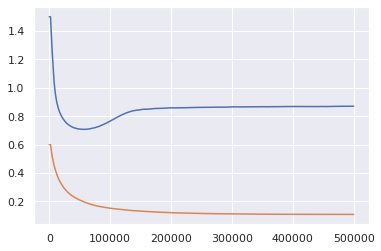

In [24]:
for k in range(2):
    plt.plot(t_ax,res_adapt[k]['gain'][:,0])
plt.show()

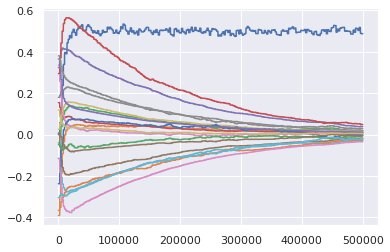

In [25]:
plt.plot(t_ax,res_adapt[1]['w_out'][:,:20])
plt.show()

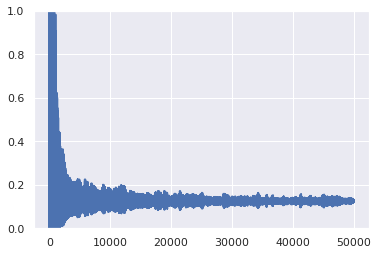

In [18]:
plt.plot(res_adapt[0]['err'])
plt.ylim([0.,1.])
plt.show()

# Testing

In [ ]:
T_test = 10000

u_in_learn,u_out_learn = gen_in_out_one_in_subs(T_test,tau)
u_in_test,u_out_test = gen_in_out_one_in_subs(T_test,tau)

### Train readouts of adapted Network

In [ ]:
ESN = ESN[0]

ESN.learn_w_out(u_in_learn,u_out_learn)

u_pred = ESN.predict_data(u_in_test)

### Train readouts of "plain Vanilla" Network (Specrad 1)

In [ ]:
ESN_unpert = esn(N=N,cf=cf,cf_w_in=cf_in)
ESN_unpert.learn_w_out(u_in_learn,u_out_learn)

u_pred_unpert = ESN_unpert.predict_data(u_in_test)

### Train readouts of Network with a copy of the adapted gains, but with newly generated random input/recurrent weights

In [ ]:
ESN_gains = esn(N=N,cf=cf,cf_w_in=cf_in)
ESN_gains.gain = ESN.gain

ESN_gains.learn_w_out(u_in_learn,u_out_learn)

u_pred_gains = ESN_gains.predict_data(u_in_test)

### Train readouts of Network of "plain Vanilla" network, with gains/spectral radius scaled to a "best guess" value

In [ ]:
ESN_rescale = esn(N=N,cf_w_in=cf_in)
ESN_rescale.gain *= .85 #np.abs(l_adapt).max()

ESN_rescale.learn_w_out(u_in_learn,u_out_learn)

u_pred_rescale = ESN_rescale.predict_data(u_in_test)

In [ ]:
l_unpert = np.linalg.eigvals(ESN_unpert.W_gain())
l_unpert_gains = np.linalg.eigvals(ESN_gains.W_gain())
l_adapt = np.linalg.eigvals(ESN.W_gain())
l_rescale = np.linalg.eigvals(ESN_rescale.W_gain())

In [ ]:
textwidth = 5.5532
path = "../plots/RTRL/"

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(textwidth,0.6*textwidth))

ax.plot(u_out_test,u_pred_unpert,'.',alpha=.5,markersize=2,label="unadapted ESN")
ax.plot(u_out_test+.1,u_pred_gains,'.',alpha=.5,markersize=2,label="ESN with adapted gains and randomized W and w_in")
ax.plot(u_out_test+.2,u_pred_rescale,'.',alpha=.5,markersize=2,label="ESN with rescaled gains")
ax.plot(u_out_test+.3,u_pred,'.',alpha=.5,markersize=2,label="adapted ESN")

ax.legend(framealpha=1.)
ax.set_xlabel("target output")
ax.set_ylabel("predicted output")

fig.tight_layout(pad=0.)

fig.savefig(path+"target_vs_prediction.png",dpi=600)
#fig.savefig(path+"target_vs_prediction.pdf",dpi=600)

plt.show()

In [ ]:
print("Correlation plain vanilla: " + str(np.corrcoef(u_out_test,u_pred_unpert)[1,0]))
print("Correlation plain vanilla with copied adapted gains: " + str(np.corrcoef(u_out_test,u_pred_gains)[1,0]))
print("Correlation plain vanilla with rescaled gains: " + str(np.corrcoef(u_out_test,u_pred_rescale)[1,0]))
print("Correlation after adaptation: " + str(np.corrcoef(u_out_test,u_pred)[1,0]))

In [ ]:
ESN = esn(N=500,cf_w_in=.1)

In [ ]:
u_in, u_out = gen_in_out_one_in_subs(100000,tau)

In [ ]:
ESN.run_adapt_RFLO(u_in,u_out)